In [1]:
import QDYN
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt
import numpy as np
from glob import glob
from os.path import join

In [2]:
def monotonic_convergence(iter, J_T):
    iter_out = []
    J_T_out = []
    J_T_prev = None
    for iter_val, J_T_val in zip(iter, J_T):
        if J_T_prev is not None:
            if J_T_prev < J_T_val:
                continue # drop
        iter_out.append(iter_val)
        J_T_out.append(J_T_val)
        J_T_prev = J_T_val
    return iter_out, J_T_out

In [3]:
def plot_convergence_comparison(runfolders, monotonic=False, xlim=None):
    conv = QDYN.octutils.OCTConvergences()
    for rf in runfolders:
        conv.load_file(
            rf.split('/')[-1],
            join(rf, 'oct_iters.dat'))
    fig, ax = plt.subplots(figsize=(10, 6))
    for (key, data) in conv.data.items():
        if monotonic:
            ax.plot(*monotonic_convergence(data.iter, data.J_T), label=key)
        else:
            ax.plot(data.iter, data.J_T, label=key)
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlabel("iteration")
    ax.set_ylabel("error")
    if xlim is not None:
        ax.set_xlim(xlim)
    plt.show(fig)

In [4]:
def rf_sort_key(rf):
    """Key for sorting runfolder according to number of trajectories"""
    try:
        a, b = rf.split('_ntrajs')
        return (a, int(b))
    except ValueError:
        return (rf, 0)

In [5]:
def plot_rho_prop_error_comparison(runfolders, xlim=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    for rf in runfolders:
        key = rf.split('/')[-1]
        oct_iter, err = np.genfromtxt(
            join(rf, 'rho_prop_error.dat'), unpack=True)
        ax.plot(oct_iter, err, label=key)
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlabel("iteration")
    ax.set_ylabel("error")
    if xlim is not None:
        ax.set_xlim(xlim)
    plt.show(fig)

## How does convergence compare between density matrix optimization and independent-trajectory optimization?

the following compares the *optimization* J_T. Values for density matrix and trajectory optimization are not directly comparable

In [6]:
ROOT = './data/method_comparison_dicke/'

In [7]:
rfs_independent_trajs =  sorted(
    glob(join(ROOT, 'T5_independent_ntrajs*')), key=rf_sort_key)

In [8]:
rf_rho = join(ROOT, 'T5_rho_ntrajs1')

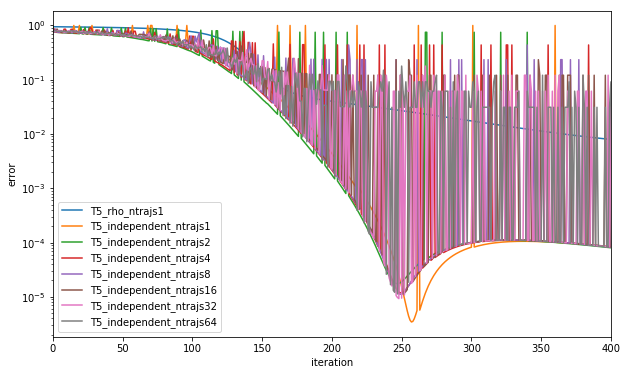

In [30]:
plot_convergence_comparison(
    [rf_rho, ] + rfs_independent_trajs, monotonic=False, xlim=(0, 400))

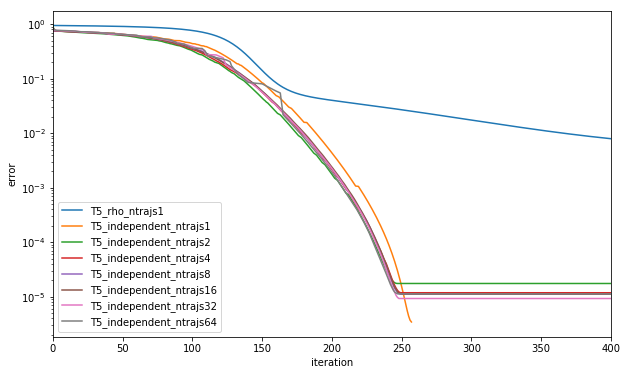

In [31]:
plot_convergence_comparison(
    [rf_rho, ] + rfs_independent_trajs, monotonic=True, xlim=(0, 400))

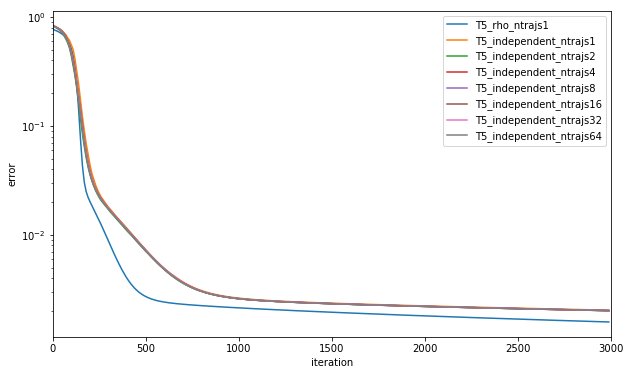

In [29]:
plot_rho_prop_error_comparison(
    [rf_rho, ] + rfs_independent_trajs, xlim=(0, 3000))

## How do the pulses compare between density matrix optimization and independent-trajectory optimization?

In [12]:
from src.notebook_plots_v1 import render_pulses

In [13]:
def plot_pulse_comparison(runfolders):
    ncols = 3
    nrows = len(runfolders) // ncols
    if ncols * nrows < len(runfolders):
        nrows += 1
    fig, axs = plt.subplots(
        figsize=(16, nrows*5), ncols=ncols, nrows=nrows, squeeze=False)
    axs = axs.flatten()
    for i, rf in enumerate(runfolders):
        ax = axs[i]
        render_pulses(ax, rf, pulses='pulse*.oct.dat')
        ax.legend()
        ax.set_xlabel("time")
        ax.set_ylabel("amplitude")
        ax.set_title(rf.split('/')[-1])
    plt.show(fig)

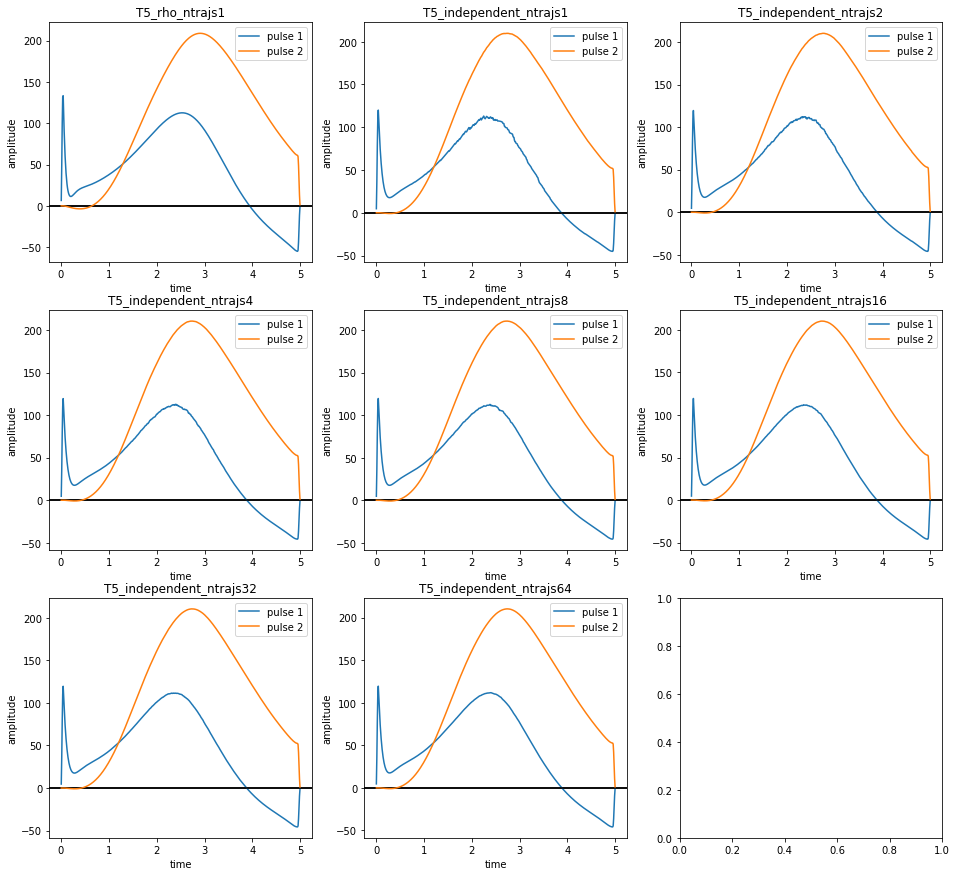

In [14]:
plot_pulse_comparison([rf_rho, ] + rfs_independent_trajs)

In [25]:
def plot_pulse_delta(runfolders):
    """Plot pulses relative to amplitudes from rho optimization"""
    ncols = 3
    nrows = len(runfolders) // ncols
    if ncols * nrows < len(runfolders):
        nrows += 1
    fig, axs = plt.subplots(
        figsize=(16, nrows*5), ncols=ncols, nrows=nrows, squeeze=False)
    axs = axs.flatten()
    pulse1_ref = QDYN.pulse.Pulse.read(join(rf_rho, 'pulse1.oct.dat'))
    pulse2_ref = QDYN.pulse.Pulse.read(join(rf_rho, 'pulse2.oct.dat'))
    for i, rf in enumerate(runfolders):
        ax = axs[i]
        pulse1 = QDYN.pulse.Pulse.read(join(rf, 'pulse1.oct.dat'))
        pulse2 = QDYN.pulse.Pulse.read(join(rf, 'pulse2.oct.dat'))
        pulse1.amplitude -= pulse1_ref.amplitude
        pulse2.amplitude -= pulse2_ref.amplitude
        pulse1.render_pulse(ax, label=r'Δ₁')
        pulse2.render_pulse(ax, label=r'Δ₂')
        ax.legend()
        ax.set_xlabel("time")
        ax.set_ylabel("amplitude")
        ax.set_title(rf.split('/')[-1])
    plt.show(fig)

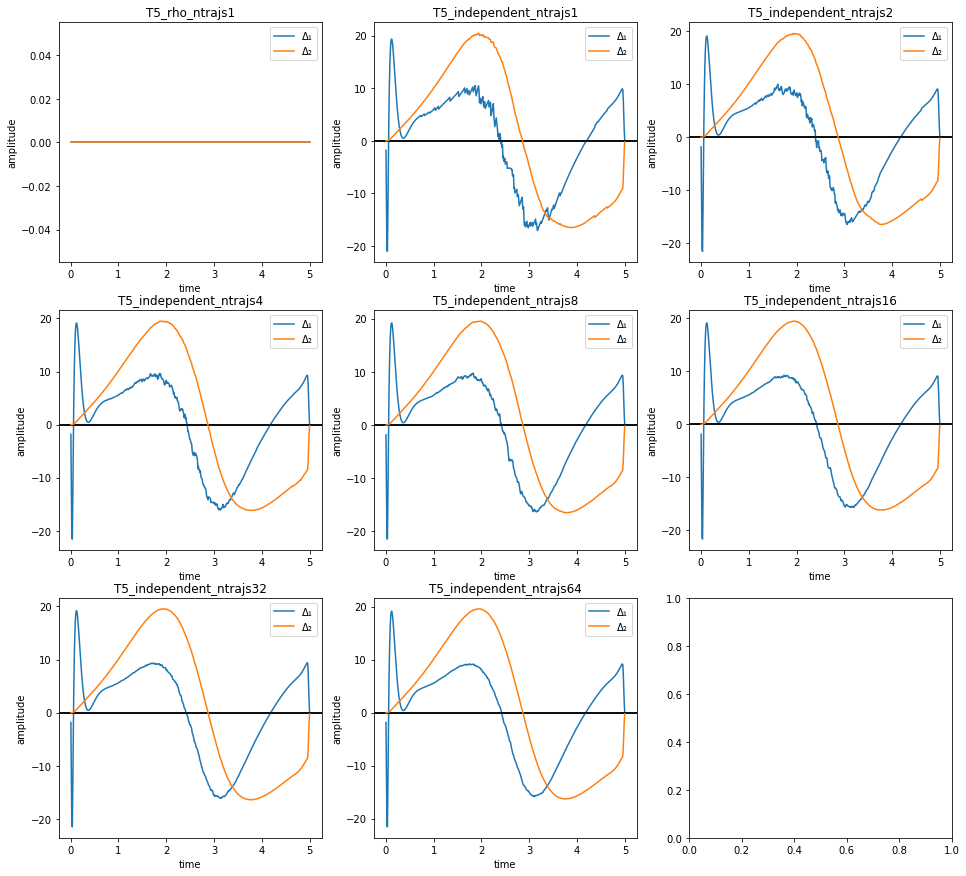

In [26]:
plot_pulse_delta([rf_rho, ] + rfs_independent_trajs)